In [2]:
## Binary classifier on an IMDB dataset.

import matplotlib.pyplot as plt
import os
import re

import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
## Get data

data_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", data_url,untar=True, cache_dir = '.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
## Content of the directory
os.listdir(dataset_dir)

In [ ]:
## Content of train directory
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

In [ ]:
## In the train directory there is a subdir of positive reviews and another subdir with negative reviews
sample_file = os.path.join(train_dir, 'neg/15_1.txt')
with open(sample_file) as f:
    print(f.read())

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
##Crear particion de validacion
seed = 123

r_training_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size= 32, validation_split= 0.2,subset='training', seed=seed
)

In [ ]:
## Mostrar algunas opiniones positivas y negativas
for text_batch, label_batch in r_training_dataset.take(1):
    for i in range(3):
        print('Review: ', text_batch.numpy()[i])
        print('Label: ',label_batch.numpy()[i])

In [ ]:
print('Label 0 is: ',r_training_dataset.class_names[0])
print('Label 1 is: ',r_training_dataset.class_names[1])


In [ ]:
r_validation_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size= 32, validation_split= 0.2,subset='validation', seed=seed
)

In [ ]:
r_testing_dataset =  tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', batch_size= 32)

In [ ]:
##Preprocesar los datos
def custom_std(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') ## estandarizacion
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')


In [ ]:
## Aplicar el TextVectorization a los datos para vectorizar y acortar el texto a un cierto tamano

max_features = 10000 ## 10000 words
seq_length = 250 ## max sequence length

vectorize_layer = TextVectorization(
    standardize = custom_std,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = seq_length
)

In [ ]:
## Index de strings a int y aplicarsela a la nueva capa
train_text = r_training_dataset.map( lambda x,y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vec_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [ ]:
text_batch, label_batch = next(iter(r_training_dataset))
first_rev, first_label = text_batch[0], label_batch[0]
print("Review: ",first_rev)
print("Label: ",first_label)
print("Vectorized review: ", vec_text(first_rev,first_label))

In [ ]:
## Podemos obtener cada token correspondiente a un int
print("Token 999: ",vectorize_layer.get_vocabulary()[999])
print("Size: ", len(vectorize_layer.get_vocabulary()))

In [ ]:
## Aplicamos este proceso a todos los datasets

training_dataset = r_training_dataset.map(vec_text)
validation_dataset = r_validation_dataset.map(vec_text)
testing_dataset = r_testing_dataset.map(vec_text)

In [ ]:
## .cache() -- mantiene los datos en la memoria
## .prefetch() -- paralelamente realiza el procesamiento de datos y la ejecucion en el entrenamiento

AUTOTUNE = tf.data.experimental.AUTOTUNE

training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
## La capa Embedding se puede utilizar siempre como primera capa y transforma los indices positivos en vectores densos y el resultado seria (batch, seq, embedding)
## GlobalAveragePooling1D manejar input de tamano variable haciendo la media de las dimensiones de las secuencias
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, 16),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.summary()

In [ ]:
## Para un problema binario de clasificacion utilizaremos la funcion de binary crossentropy

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),optimizer = 'adam', metrics=tf.metrics.BinaryAccuracy(threshold = 0.0))

In [ ]:
## Entrenamos el modelo
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 10
)


In [ ]:
## Para ver como se ha desempeñado el modelo
loss_val, accuracy_val = model.evaluate(testing_dataset)

print("Loss val: ", loss_val)
print("Accuracy val: ", accuracy_val)

In [ ]:

## Utilizamos el objeto History para saber diferentes valores del entrenamiento

history_dict = history.history

acc_val = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc_val) + 1)
## Creamos el plot para mostrar el loss y val_loss durante los epochs

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
## Y para el accuracy
plt.plot(epochs, acc_val, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
## Vemos por los graficos que aparece el overfitting ya que los datos se comportan mejor en el training que en datos que no ha visto antes.

In [ ]:
## Para exportar nuestro modelo creado

exported_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

exported_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

## Test it with the testing dataset

loss_val, acc_val = exported_model.evaluate(r_testing_dataset)
print("Loss: {}, Accuracy: {}".format(loss_val,acc_val))

In [ ]:
## Para predecir a partir de nuevos datos

examples = [
    "Great movie",
    "Terrible movie !!!",
    "This movie was ok but I wouldn't recommend it to anyone"
]
exported_model.predict(examples)

In [6]:
## StackOverflow example

## Get data

data_url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", data_url,untar=True, cache_dir = '.')



6053888/6053168 [==============================] - 1s 0us/step


In [10]:
os.listdir('stackO')

train_dir = os.path.join('stackO', 'train')
os.listdir(train_dir)

['javascript', 'csharp', 'java', 'python']

In [13]:
with open('stackO/train/python/13.txt') as f:
    print(f.read())

"setting a set to the contents of a global set i'm making a program in which i use 6 global sets. inside of various functions that are called i make temporary backup of those sets by doing something like temp_set = set. when i do this, the temporary set is somehow modified when i changed the original set. i assume that blank is setting temp_set to a pointer to the original set here. how can i prevent it from doing this. rapid response would be immensely appreciated."



In [14]:
##Crear particion de validacion
seed = 123

r_training_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    'stackO/train', batch_size= 32, validation_split= 0.2,subset='training', seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [16]:
for que_batch, cat_batch in r_training_dataset.take(1):
    for i in range(3):
        print('Question: ', que_batch.numpy()[i])
        print('Category: ',cat_batch.numpy()[i])

Question:  b'"can you use a or (||) operator inside a ternary operator condition statment in to determina if null or undefined when i try and check if a value is undefined or null the undefined variable get\'s checked but not the null value i am doing this inside a click handler for google maps ..map.data.addlistener(\'click\', function(event) {.var altitudemode = event.feature.getproperty(\'altitudemode\') === undefined || null ?  .  """" .: .  ""&lt;tbody&gt;""+""&lt;th&gt;altitudemode:&lt;/th&gt;"" + ""&lt;td&gt;"" + event.feature.getproperty(\'altitudemode\') + ""&lt;/td&gt;"" + ""&lt;/tbody&gt;"";.}"\n'
Category:  2
Question:  b'"how can i find duplicate values of an array of objects json, also i need to unify them like this: im doing a pie chart with d3 and i need to filter objects  json of an array with the date that they contain so if i put last day it only has to show me the objects that has the same date that today(that\'s done), the problem comes when i want to filter it las

In [17]:
### See categories

print('Cat 0 is: ',r_training_dataset.class_names[0])
print('Cat 1 is: ',r_training_dataset.class_names[1])
print('Cat 2 is: ',r_training_dataset.class_names[2])
print('Cat 3 is: ',r_training_dataset.class_names[3])

Cat 0 is:  csharp
Cat 1 is:  java
Cat 2 is:  javascript
Cat 3 is:  python


In [18]:
r_validation_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    'stackO/train', batch_size= 32, validation_split= 0.2,subset='validation', seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [19]:
r_testing_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    'stackO/test', batch_size= 32)

Found 8000 files belonging to 4 classes.


In [20]:
##Preprocesar los datos
def custom_std(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') ## estandarizacion
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')


In [21]:
## Aplicar el TextVectorization a los datos para vectorizar y acortar el texto a un cierto tamano

max_features = 10000 ## 10000 words
seq_length = 250 ## max sequence length

vectorize_layer = TextVectorization(
    standardize = custom_std,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = seq_length
)

In [22]:
## Index de strings a int y aplicarsela a la nueva capa
train_text = r_training_dataset.map( lambda x,y: x)
vectorize_layer.adapt(train_text)

In [23]:
def vec_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [24]:
que_batch, cat_batch = next(iter(r_training_dataset))
first_que, first_cat = que_batch[0], cat_batch[0]
print("Question: ",first_que)
print("Category: ",first_cat)
print("Vectorized question: ", vec_text(first_que,first_cat))

Question:  tf.Tensor(b'"blank: display not changing from ""block"" to ""none"" after clicking elements (the red square), the func function gets called and it gets the first child node, then that node changes it\'s children display to block. now, i\'m trying to set them back to none after clicking background_dim (the dark background) by getting background_dim\'s parent node, then iterating throught the children and setting their display to none. but apparently this doesn\'t work. it only works if i set their position to relative, but i\'d have to change the other function as well.....function func(element) {.  var _first_child = element.children[0];.  for (var i = 0; i &lt; _first_child.children.length; ++i).    _first_child.children[i].style.display = ""block"";.}..function func_t(element) {.  var _parent = element.parentnode;.  for (var i = 0; i &lt; _parent.children.length; ++i).    _parent.children[i].style.display = ""none"";.}..elements {.  width: 40px;.  height: 40px;.  backgroun

In [25]:
## Podemos obtener cada token correspondiente a un int
print("Token 999: ",vectorize_layer.get_vocabulary()[999])
print("Size: ", len(vectorize_layer.get_vocabulary()))

Token 999:  including
Size:  10000


In [26]:
## Aplicamos este proceso a todos los datasets

training_dataset = r_training_dataset.map(vec_text)
validation_dataset = r_validation_dataset.map(vec_text)
testing_dataset = r_testing_dataset.map(vec_text)

In [27]:
## .cache() -- mantiene los datos en la memoria
## .prefetch() -- paralelamente realiza el procesamiento de datos y la ejecucion en el entrenamiento

AUTOTUNE = tf.data.experimental.AUTOTUNE

training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
## La capa Embedding se puede utilizar siempre como primera capa y transforma los indices positivos en vectores densos y el resultado seria (batch, seq, embedding)
## GlobalAveragePooling1D manejar input de tamano variable haciendo la media de las dimensiones de las secuencias
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, 16),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4) ## 4 categories
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [34]:
## Para un problema multiclase de clasificacion utilizaremos la funcion de SparseCategoricalCrossentropy

model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),optimizer = 'adam', metrics=['accuracy'])

In [40]:
## Entrenamos el modelo
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 15
)

Epoch 1/15
200/200 [==============================] - 1s 5ms/step - loss: 0.5146 - accuracy: 0.8569 - val_loss: 0.6567 - val_accuracy: 0.7800
Epoch 2/15
200/200 [==============================] - 1s 7ms/step - loss: 0.4911 - accuracy: 0.8692 - val_loss: 0.6458 - val_accuracy: 0.7788
Epoch 3/15
200/200 [==============================] - 1s 7ms/step - loss: 0.4783 - accuracy: 0.8664 - val_loss: 0.6358 - val_accuracy: 0.7850
Epoch 4/15
200/200 [==============================] - 1s 7ms/step - loss: 0.4606 - accuracy: 0.8728 - val_loss: 0.6259 - val_accuracy: 0.7850
Epoch 5/15
200/200 [==============================] - 1s 7ms/step - loss: 0.4479 - accuracy: 0.8817 - val_loss: 0.6177 - val_accuracy: 0.7912
Epoch 6/15
200/200 [==============================] - 1s 7ms/step - loss: 0.4288 - accuracy: 0.8847 - val_loss: 0.6096 - val_accuracy: 0.7900
Epoch 7/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4145 - accuracy: 0.8880 - val_loss: 0.6032 - val_accuracy: 0.7944
Epoch 

In [41]:
## Para ver como se ha desempeñado el modelo
loss_val, accuracy_val = model.evaluate(testing_dataset)

print("Loss val: ", loss_val)
print("Accuracy val: ", accuracy_val)

250/250 [==============================] - 0s 778us/step - loss: 0.5397 - accuracy: 0.8045
Loss val:  0.5396743416786194
Accuracy val:  0.8044999837875366


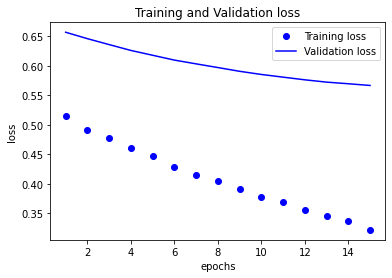

In [42]:
## Utilizamos el objeto History para saber diferentes valores del entrenamiento

history_dict = history.history

acc_val = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc_val) + 1)
## Creamos el plot para mostrar el loss y val_loss durante los epochs

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

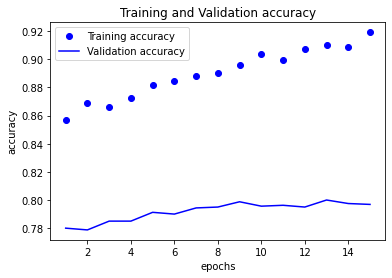

In [43]:
## Y para el accuracy
plt.plot(epochs, acc_val, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [44]:
## Para exportar nuestro modelo creado

exported_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

exported_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

## Test it with the testing dataset

loss_val, acc_val = exported_model.evaluate(r_testing_dataset)
print("Loss: {}, Accuracy: {}".format(loss_val,acc_val))

250/250 [==============================] - 9s 38ms/step - loss: 1.0795 - accuracy: 0.8045
Loss: 1.0794792175292969, Accuracy: 0.8044999837875366


In [45]:
## Para predecir a partir de nuevos datos

examples = [
    "I've multiple models in my Django project but only this given below model creating another instance on update instead of save. This is happening in Django's Admin panel, not on my custom UI",
    "I have built a slider using flexbox. This slider is composed of 4 parts, each one containing 12 slides",
    "Getting error: incompatible types: int cannot be converted to T. I want to build a queue using linked list that can store items of different data types"
]
exported_model.predict(examples)

array([[0.6507952 , 0.35672688, 0.51864886, 0.46409193],
       [0.5231365 , 0.38318986, 0.60764754, 0.5120296 ],
       [0.64410037, 0.6810206 , 0.27678007, 0.3036365 ]], dtype=float32)